In [2]:
""" 
We will use subversion to get only 1 folder from our github repo, 
instead of cloning the entire repository using git.clone
(Done by replacing ".../tree/main/S8" with ".../trunk/S8" in the git folder url)
"""
!apt install subversion
!pip install albumentations==0.4.6
!pip install pytorch-gradcam

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [3]:
!svn update S9
!svn checkout https://github.com/AkhilP9182/EVA5---Extensive-Vision-AI/trunk/S9

Skipped 'S9'
svn: E155007: None of the targets are working copies
A    S9/README.md
A    S9/config.py
A    S9/images
A    S9/images/sd
A    S9/models
A    S9/models/sf
A    S9/resnet.py
A    S9/train_test.py
A    S9/utilities.py
Checked out revision 161.


In [4]:
""" Our folder S9 (which contains all the required files) has been downloaded into the root folder"""
%ls

S9/  sample_data/


In [5]:
import os
folder_name = "S9/"
print("Python files in the folder {}".format(folder_name))
for root, dirs, files in os.walk(folder_name):
    for filename in files:
        if (".py" in filename and ".pyc" not in filename):
            print(filename)

Python files in the folder S9/
resnet.py
utilities.py
config.py
train_test.py


We can see that all the required files have been downloaded

## **[1] Importing required packages**

In [6]:
# Importing the necessary packages
import sys
import numpy as np
import torch
import torchvision
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets
import torch.utils.data
import torchvision.transforms as transforms
import matplotlib.pyplot      as plt
from   torchsummary       import summary
import tqdm.notebook as tq
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Importing the custom classes and functions
import S9.config as config
import S9.utilities as util
from S9.resnet import ResNet18
from S9.train_test import train,test

## **[2] Load Train/Test datasets (with the new mean and std deviation normalization)**

### [2.1] Calculate mean and std. deviation of combined (train+test) data

In [8]:
SEED = 1  # Set Randomization seed for Reproducible results
torch.manual_seed(SEED)                 

if config.USE_CUDA:
    torch.cuda.manual_seed(SEED)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform = util.to_tensor)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = util.to_tensor)
# Train and Test set here are torch tensors
mean_cifar10, std_cifar10 = util.get_mean_std_overall(trainset,testset)

mean_cifar10 = tuple(mean_cifar10.numpy())
std_cifar10 = tuple(std_cifar10.numpy())

print("\nChannelwise Mean of overall CIFAR 10 dataset:\t\t\t{}".format(mean_cifar10))         # mean_cifar10 = (0.49186122, 0.48266134, 0.44720834)
print("Channelwise Standrad Deviation of overall CIFAR 10 dataset:\t{}\n".format(std_cifar10)) # std_cifar10 = (0.24699295, 0.24340236, 0.26160896)

util.dataset_info(trainset,testset)
del trainset,testset

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Channelwise Mean of overall CIFAR 10 dataset:			(0.49186122, 0.48266134, 0.44720834)
Channelwise Standrad Deviation of overall CIFAR 10 dataset:	(0.24699295, 0.24340236, 0.26160896)

Number of classes in CIFAR10   : 10
Number of images for training  : 50000
Number of images for validation: 10000


### [2.2] Getting the PIL image list which would feed into the Albumentation Data fetcher class

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform = None)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = None)
# Train and Test set here are PIL images
train_images, train_labels, _, _  = util.get_PIL_images(trainset)
print("Train Images loaded")
test_images, test_labels, _,_ = util.get_PIL_images(testset)
print("Test Images loaded")

Files already downloaded and verified
Files already downloaded and verified
Train Images loaded
Test Images loaded


### [2.3] Use Albumentation Dataset creator to create a training and testing set

In [10]:
trainset = util.AlbumentateTrainData(image_list = train_images, labels=train_labels, 
                                     mean = mean_cifar10, std = std_cifar10)
testset  = util.AlbumentateTestData(image_list  = test_images,  labels= test_labels, 
                                    mean = mean_cifar10, std = std_cifar10)
# The mean and std for CIFAR10 are already saved in config.py file, for the train and test loaders respectively

train_loader  = util.train_loader_cifar10(trainset, shuffle = True , num_workers = config.num_workers)
test_loader   = util.test_loader_cifar10(testset,   shuffle = False, num_workers = config.num_workers)

classes = config.CIFAR_classes
print(classes)
num_classes = len(classes)
print("\nNumber of classes = {}".format(num_classes))

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Number of classes = 10


### [2.4] Plot some images from test set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


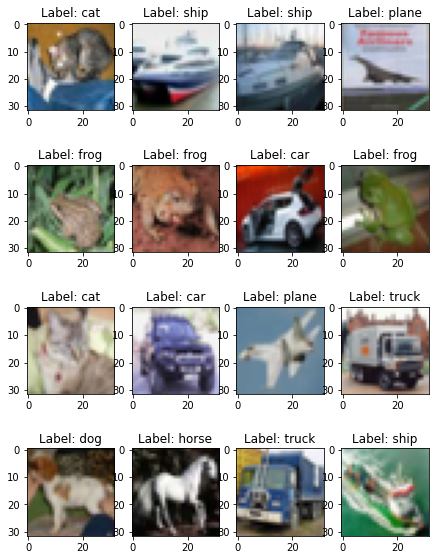

In [12]:
util.plot_images(test_loader, rows=4, cols=4, 
                 mean = mean_cifar10, std=std_cifar10, 
                 classes = list(config.CIFAR_classes))

## **[3] Resnet Model**

In [13]:
device = config.DEVICE                                # Selects whether to run the model on GPU or CPU
model = ResNet18().to(device)                         # Loads the model weights on the gpu or cpu
summary(model, input_size=config.input_size_CIFAR10)  # Shows the sizes of the input and output at each layers for a given input image size, and total parameters

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## **[4] Training and Testing the model**

In [14]:
epochs = config.EPOCHS             # No. of training epochs

train_loss_vals = []
train_acc_vals  = []
test_loss_vals  = []
test_acc_vals   = []

optimizer = optim.SGD(model.parameters(), lr=config.LR, momentum=config.MOMENTUM) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = config.LR_STEP, gamma=config.LR_GAMMA)
# 

max_test_acc = 0
for epoch in range(0, epochs):
    train_loss,train_acc = train(model, config.DEVICE, train_loader, optimizer, epoch, L2_param = 0.005)
    test_loss,test_acc   = test(model, config.DEVICE, test_loader)
    if (test_acc > max_test_acc): # Save the best performing model
        model_path = 'S9/models/S9_best_resnet18_model_with_albument.model'
        torch.save(model.state_dict(), model_path)
        max_test_acc = test_acc
        print("Model saved at epoch {}".format(epoch))
    scheduler.step()       # FOR LR UPDATE
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    train_acc_vals.append(train_acc)
    test_acc_vals.append(test_acc)


Epoch:0 Learning Rate:0.01
Train Set: Mean loss: 1.2653, Train Accuracy: 27222/50000 (54.44%)
Test Set : Mean loss: 1.2237, Test Accuracy : 5660/10000 (56.60%)

Model saved at epoch 0



Epoch:1 Learning Rate:0.01
Train Set: Mean loss: 1.0538, Train Accuracy: 31445/50000 (62.89%)
Test Set : Mean loss: 0.9631, Test Accuracy : 6671/10000 (66.71%)

Model saved at epoch 1



Epoch:2 Learning Rate:0.01
Train Set: Mean loss: 0.8531, Train Accuracy: 35024/50000 (70.05%)
Test Set : Mean loss: 0.7537, Test Accuracy : 7390/10000 (73.90%)

Model saved at epoch 2



Epoch:3 Learning Rate:0.01
Train Set: Mean loss: 0.8173, Train Accuracy: 35719/50000 (71.44%)
Test Set : Mean loss: 0.7042, Test Accuracy : 7524/10000 (75.24%)

Model saved at epoch 3



Epoch:4 Learning Rate:0.008
Train Set: Mean loss: 0.7682, Train Accuracy: 36515/50000 (73.03%)
Test Set : Mean loss: 0.6969, Test Accuracy : 7596/10000 (75.96%)

Model saved at epoch 4



Epoch:5 Learning Rate:0.008
Train Set: Mean loss: 0.7760, Train Accuracy: 36587/50000 (73.17%)
Test Set : Mean loss: 0.7290, Test Accuracy : 7548/10000 (75.48%)




Epoch:6 Learning Rate:0.008
Train Set: Mean loss: 0.6642, Train Accuracy: 38726/50000 (77.45%)
Test Set : Mean loss: 0.6282, Test Accuracy : 7886/10000 (78.86%)

Model saved at epoch 6



Epoch:7 Learning Rate:0.008
Train Set: Mean loss: 0.6773, Train Accuracy: 38462/50000 (76.92%)
Test Set : Mean loss: 0.6182, Test Accuracy : 7896/10000 (78.96%)

Model saved at epoch 7



Epoch:8 Learning Rate:0.0064
Train Set: Mean loss: 0.6395, Train Accuracy: 39034/50000 (78.07%)
Test Set : Mean loss: 0.5645, Test Accuracy : 8091/10000 (80.91%)

Model saved at epoch 8



Epoch:9 Learning Rate:0.0064
Train Set: Mean loss: 0.5780, Train Accuracy: 40211/50000 (80.42%)
Test Set : Mean loss: 0.5433, Test Accuracy : 8178/10000 (81.78%)

Model saved at epoch 9



Epoch:10 Learning Rate:0.0064
Train Set: Mean loss: 0.6195, Train Accuracy: 39495/50000 (78.99%)
Test Set : Mean loss: 0.5984, Test Accuracy : 7966/10000 (79.66%)




Epoch:11 Learning Rate:0.0064
Train Set: Mean loss: 0.5308, Train Accuracy: 41036/50000 (82.07%)
Test Set : Mean loss: 0.4883, Test Accuracy : 8353/10000 (83.53%)

Model saved at epoch 11



Epoch:12 Learning Rate:0.00512
Train Set: Mean loss: 0.4464, Train Accuracy: 42544/50000 (85.09%)
Test Set : Mean loss: 0.4380, Test Accuracy : 8507/10000 (85.07%)

Model saved at epoch 12



Epoch:13 Learning Rate:0.00512
Train Set: Mean loss: 0.5847, Train Accuracy: 39817/50000 (79.63%)
Test Set : Mean loss: 0.5194, Test Accuracy : 8220/10000 (82.20%)




Epoch:14 Learning Rate:0.00512
Train Set: Mean loss: 0.5145, Train Accuracy: 41321/50000 (82.64%)
Test Set : Mean loss: 0.4770, Test Accuracy : 8374/10000 (83.74%)




Epoch:15 Learning Rate:0.00512
Train Set: Mean loss: 0.4599, Train Accuracy: 42075/50000 (84.15%)
Test Set : Mean loss: 0.4493, Test Accuracy : 8435/10000 (84.35%)




Epoch:16 Learning Rate:0.004096000000000001
Train Set: Mean loss: 0.4253, Train Accuracy: 42632/50000 (85.26%)
Test Set : Mean loss: 0.4286, Test Accuracy : 8524/10000 (85.24%)

Model saved at epoch 16



Epoch:17 Learning Rate:0.004096000000000001
Train Set: Mean loss: 0.4413, Train Accuracy: 42656/50000 (85.31%)
Test Set : Mean loss: 0.4677, Test Accuracy : 8448/10000 (84.48%)




Epoch:18 Learning Rate:0.004096000000000001
Train Set: Mean loss: 0.4198, Train Accuracy: 42954/50000 (85.91%)
Test Set : Mean loss: 0.4336, Test Accuracy : 8543/10000 (85.43%)

Model saved at epoch 18



Epoch:19 Learning Rate:0.004096000000000001
Train Set: Mean loss: 0.4280, Train Accuracy: 42587/50000 (85.17%)
Test Set : Mean loss: 0.4567, Test Accuracy : 8433/10000 (84.33%)




Epoch:20 Learning Rate:0.0032768000000000007
Train Set: Mean loss: 0.3728, Train Accuracy: 43880/50000 (87.76%)
Test Set : Mean loss: 0.4155, Test Accuracy : 8626/10000 (86.26%)

Model saved at epoch 20



Epoch:21 Learning Rate:0.0032768000000000007
Train Set: Mean loss: 0.4074, Train Accuracy: 43085/50000 (86.17%)
Test Set : Mean loss: 0.4420, Test Accuracy : 8545/10000 (85.45%)




Epoch:22 Learning Rate:0.0032768000000000007
Train Set: Mean loss: 0.3626, Train Accuracy: 43946/50000 (87.89%)
Test Set : Mean loss: 0.3933, Test Accuracy : 8693/10000 (86.93%)

Model saved at epoch 22



Epoch:23 Learning Rate:0.0032768000000000007
Train Set: Mean loss: 0.3400, Train Accuracy: 44372/50000 (88.74%)
Test Set : Mean loss: 0.3758, Test Accuracy : 8771/10000 (87.71%)

Model saved at epoch 23



Epoch:24 Learning Rate:0.002621440000000001
Train Set: Mean loss: 0.3482, Train Accuracy: 44031/50000 (88.06%)
Test Set : Mean loss: 0.4050, Test Accuracy : 8633/10000 (86.33%)




Epoch:25 Learning Rate:0.002621440000000001
Train Set: Mean loss: 0.3029, Train Accuracy: 45014/50000 (90.03%)
Test Set : Mean loss: 0.3396, Test Accuracy : 8845/10000 (88.45%)

Model saved at epoch 25



Epoch:26 Learning Rate:0.002621440000000001
Train Set: Mean loss: 0.2970, Train Accuracy: 45126/50000 (90.25%)
Test Set : Mean loss: 0.3574, Test Accuracy : 8810/10000 (88.10%)




Epoch:27 Learning Rate:0.002621440000000001
Train Set: Mean loss: 0.3382, Train Accuracy: 44498/50000 (89.00%)
Test Set : Mean loss: 0.3854, Test Accuracy : 8717/10000 (87.17%)




Epoch:28 Learning Rate:0.002097152000000001
Train Set: Mean loss: 0.2819, Train Accuracy: 45412/50000 (90.82%)
Test Set : Mean loss: 0.3575, Test Accuracy : 8868/10000 (88.68%)

Model saved at epoch 28



Epoch:29 Learning Rate:0.002097152000000001
Train Set: Mean loss: 0.2754, Train Accuracy: 45431/50000 (90.86%)
Test Set : Mean loss: 0.3107, Test Accuracy : 8953/10000 (89.53%)

Model saved at epoch 29



Epoch:30 Learning Rate:0.002097152000000001
Train Set: Mean loss: 0.2738, Train Accuracy: 45566/50000 (91.13%)
Test Set : Mean loss: 0.3118, Test Accuracy : 8962/10000 (89.62%)

Model saved at epoch 30



Epoch:31 Learning Rate:0.002097152000000001
Train Set: Mean loss: 0.3154, Train Accuracy: 44757/50000 (89.51%)
Test Set : Mean loss: 0.3916, Test Accuracy : 8747/10000 (87.47%)




Epoch:32 Learning Rate:0.001677721600000001
Train Set: Mean loss: 0.1916, Train Accuracy: 47011/50000 (94.02%)
Test Set : Mean loss: 0.2962, Test Accuracy : 9035/10000 (90.35%)

Model saved at epoch 32



Epoch:33 Learning Rate:0.001677721600000001
Train Set: Mean loss: 0.2076, Train Accuracy: 46693/50000 (93.39%)
Test Set : Mean loss: 0.3120, Test Accuracy : 8992/10000 (89.92%)




Epoch:34 Learning Rate:0.001677721600000001
Train Set: Mean loss: 0.2076, Train Accuracy: 46605/50000 (93.21%)
Test Set : Mean loss: 0.3229, Test Accuracy : 8941/10000 (89.41%)



KeyboardInterrupt: ignored

## **[5] Loss and Accuracy Plots**

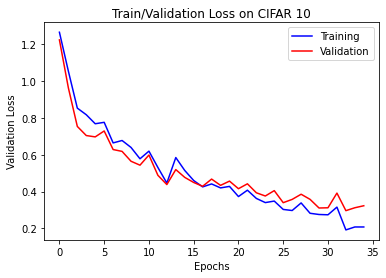

In [16]:
util.plot_loss(train_loss_vals,test_loss_vals,epoch)

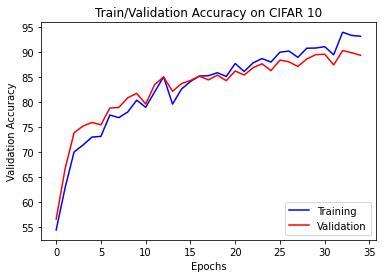

In [17]:
util.plot_acc(train_acc_vals,test_acc_vals,epoch)

## **[6] Plot Correctly Classified Images, their predictions and their GradCAM Heatmaps**

Following are the correctly classified images:-


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


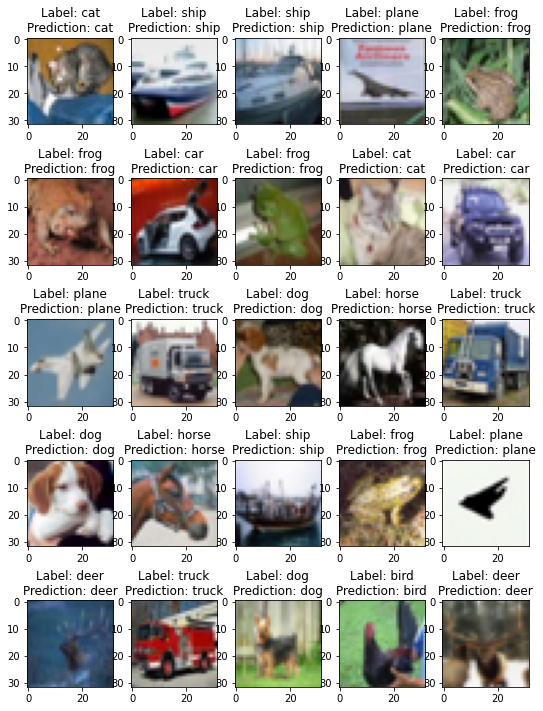

Following are the GradCam Heatmaps for those correctly classified images:-


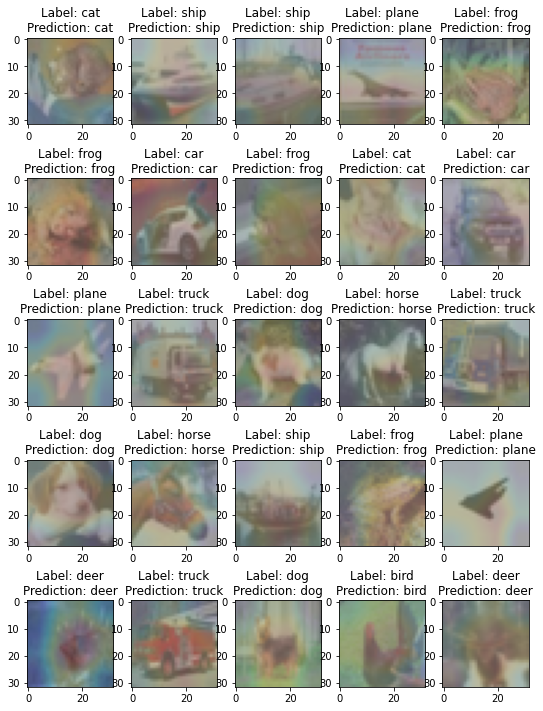

In [25]:
util.plot_correct_classified(ResNet18,"S9/models/S9_best_resnet18_model_with_albument.model",test_loader,
                   mean=mean_cifar10, std=std_cifar10,
                   classes=config.CIFAR_classes)

## **[7] Plot Misclassified Images, their predictions and their GradCAM Heatmaps**

Following are the mis-classified images:-


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


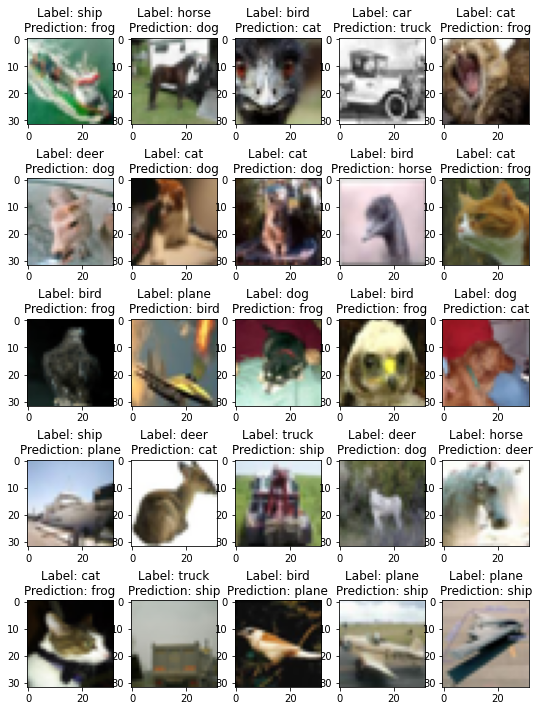

Following are the GradCam Heatmaps for those mis-classified images:-


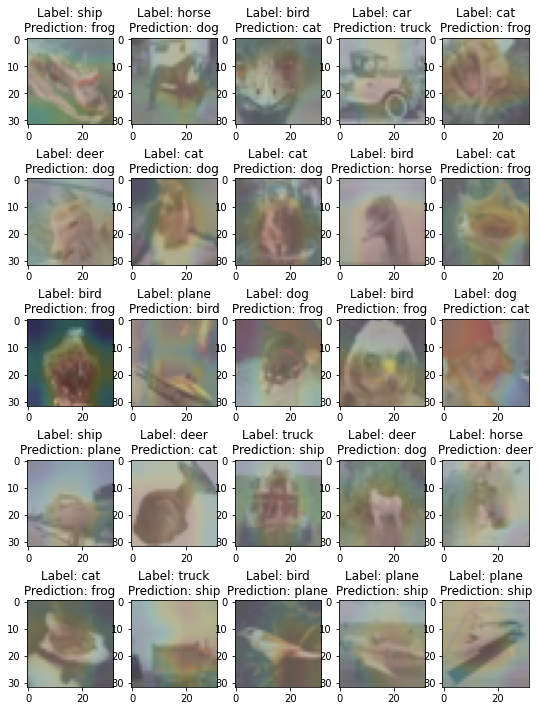

In [23]:
util.plot_misclassified(ResNet18,"S9/models/S9_best_resnet18_model_with_albument.model",test_loader,
                   mean=mean_cifar10, std=std_cifar10,
                   classes=config.CIFAR_classes)